In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as curve_fit
from scipy.optimize import minimize as minimize
from uncertainties import ufloat
from uncertainties import unumpy
from uncertainties.umath import *
from uncertainties.unumpy import nominal_values as nv
from uncertainties.unumpy import std_devs as sd
from lmfit import Model
from functools import partial
%matplotlib inline

# 7. Aluminum background

In [2]:
albg_t_s = ufloat(3545,1)
albg_N = ufloat(1000,sqrt(1000))
albg_I = albg_N/albg_t_s
albg_I

0.2820874471086037+/-0.008920743227486653

In [3]:
al_bg = pd.DataFrame()
al_bg["t_s"]=[3545]
al_bg["N"] = [1000]
al_bg["I"] = al_bg.N/al_bg.t_s
al_bg["dI"] = np.sqrt(al_bg.N)/al_bg.t_s
al_bg

t_s     N         I       dI
0  3545  1000  0.282087  0.00892

In [4]:
sqrt(1000)/3545

0.008920388322054667

# 2. Effective range of electrons

## Data preparation

In [5]:
eff_range = pd.read_csv('2_Eff_range.csv')
eff_range = eff_range.sort_values("d_mm")
erange_N = unumpy.uarray(eff_range.N,np.sqrt(eff_range.N))
erange_t = unumpy.uarray(eff_range.t_s,np.ones(eff_range.t_s.shape[0]))
erange_d = unumpy.uarray(eff_range.d_mm,eff_range.dd_mm.shape[0])
erange_I = erange_N/erange_t-albg_I
erange_N,erange_t,erange_d,erange_I

(array([8943.0+/-94.56743625582752, 4784.0+/-69.16646586316233,
        3167.0+/-56.27610505356603, 2354.0+/-48.518037882832814,
        2191.0+/-46.8081189538738, 1780.0+/-42.190046219457976,
        1275.0+/-35.70714214271425, 1071.0+/-32.72613634390714,
        836.0+/-28.91366458960192, 1081.0+/-32.87856444554719,
        1006.0+/-31.71750305430741, 1002.0+/-31.654383582688826,
        1004.0+/-31.68595903550972], dtype=object),
 array([60.0+/-1.0, 60.0+/-1.0, 60.0+/-1.0, 60.0+/-1.0, 60.0+/-1.0,
        60.0+/-1.0, 60.0+/-1.0, 60.0+/-1.0, 60.0+/-1.0, 92.0+/-1.0,
        122.0+/-1.0, 540.0+/-1.0, 990.0+/-1.0], dtype=object),
 array([0.0+/-13.0, 0.1+/-13.0, 0.2+/-13.0, 0.3+/-13.0, 0.35+/-13.0,
        0.4+/-13.0, 0.55+/-13.0, 0.65+/-13.0, 0.75+/-13.0, 0.83+/-13.0,
        1.1+/-13.0, 2.1+/-13.0, 3.1+/-13.0], dtype=object),
 array([148.7679125528914+/-2.9419942681970297,
        79.45124588622473+/-1.759236808266859,
        52.50124588622473+/-1.2859677251601447,
        38.951245886

In [6]:
unumpy.nominal_values(erange_I)

array([148.76791255,  79.45124589,  52.50124589,  38.95124589,
        36.23457922,  29.38457922,  20.96791255,  17.56791255,
        13.65124589,  11.46791255,   7.96381419,   1.57346811,
         0.73205397])

## Empirical values

$$\rho R_{eff} (g/cm^2) = [0.54 E_{max} (MeV) - 0.13], \quad\quad\quad E_{max}>0.8MeV$$
$$\rho R_{eff} (g/cm^2) = 0.41 E_{max}^{1.38} (MeV), \quad\quad 0.15MeV<E_{max}<0.8MeV$$

In [7]:
rho = 2.7
d_Y = (0.54*2.29-0.13)*10/2.7
d_Sr = 0.41*(0.546**1.38)*10/2.7
print(f"Theoretical range ({d_Sr:.2f}:{d_Y:.2f})mm")

Theoretical range (0.66:4.10)mm


### Fitting weighted sum of two exponentials using lmfit

[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 101
    # data points      = 13
    # variables        = 4
    chi-square         = 144.194204
    reduced chi-square = 16.0215782
    Akaike info crit   = 39.2807518
    Bayesian info crit = 41.5405492
[[Variables]]
    A1:  102.763801 +/- 10.6442200 (10.36%) (init = 74.38396)
    t1: -6.54538041 +/- 0.98404852 (15.03%) (init = -1)
    A2:  37.0972059 +/- 6.02966595 (16.25%) (init = 74.38396)
    t2: -1.41095740 +/- 0.10188492 (7.22%) (init = -1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A2, t2) = -0.904
    C(t1, A2) = -0.777
    C(t1, t2) =  0.634
    C(A1, t2) =  0.326
    C(A1, A2) = -0.319
    C(A1, t1) = -0.148


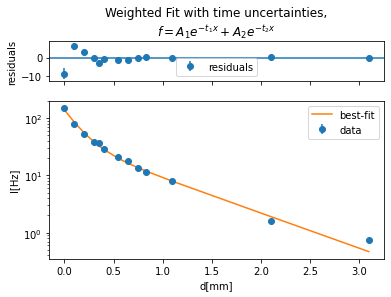

In [8]:
decay = lambda x,A,t: A*np.exp(x*t)
double_decay = lambda x,A1,t1,A2,t2: decay(x,A1,t1)+decay(x,A2,t2)
ddmodel = Model(double_decay)
# for par in ddmodel.param_names:
ddmodel.set_param_hint("A1",min = 0)
ddmodel.set_param_hint("A2",min = 0)
ddmodel.set_param_hint("t1",max = 0)
ddmodel.set_param_hint("t2",max = 0)
ddresult = ddmodel.fit(nv(erange_I),x=eff_range.d_mm,A1=nv(erange_I).max()/2,
                       A2=nv(erange_I).max()/2,t1=-1,t2=-1,weights=1/sd(erange_I))
fig = plt.figure()
fig, gridspec = ddresult.plot(fig=fig,yerr=unumpy.std_devs(erange_I),ylabel='I[Hz]',xlabel='d[mm]')
fig.get_axes()[0].set_title("Weighted Fit with time uncertainties,\n$f=A_1e^{-t_1x}+A_2e^{-t_2x}$")
fig.get_axes()[1].set_yscale("log")
print(str.format(ddresult.fit_report()))

In [9]:
print(-np.log(1/1000)/ufloat(ddresult.params['t1'].value,ddresult.params['t1'].stderr))
print(-np.log(1/1000)/ufloat(ddresult.params['t2'].value,ddresult.params['t2'].stderr))

-1.06+/-0.16
-4.90+/-0.35


### Sum of exponentials with same amplitude

[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 13
    # variables        = 3
    chi-square         = 402.689925
    reduced chi-square = 40.2689925
    Akaike info crit   = 50.6318274
    Bayesian info crit = 52.3266754
[[Variables]]
    A1:  61.0571450 +/- 7.60192014 (12.45%) (init = 74.38396)
    t1: -1.79580755 +/- 0.12841991 (7.15%) (init = -1)
    t2: -9.18038882 +/- 4.32259730 (47.09%) (init = -10)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, t2) = -0.813
    C(A1, t1) = -0.781
    C(t1, t2) =  0.536


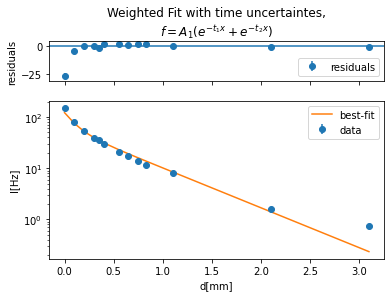

In [10]:
decay = lambda x,A,t: A*np.exp(x*t)
double_decay = lambda x,A1,t1,t2: decay(x,A1,t1)+decay(x,A1,t2)
ddmodel = Model(double_decay)
# for par in ddmodel.param_names:
ddmodel.set_param_hint("A1",min = 0)
ddmodel.set_param_hint("t1",max = 0)
ddmodel.set_param_hint("t2",max = 0)
ddresult = ddmodel.fit(nv(erange_I),x=nv(erange_d),A1=nv(erange_I).max()/2,
                       t1=-1,t2=-10,weights=1/sd(erange_I))
fig = plt.figure()
fig, gridspec = ddresult.plot(fig=fig,yerr=sd(erange_I),ylabel='I[Hz]',xlabel='d[mm]')
fig.get_axes()[1].set_yscale("log")
fig.get_axes()[0].set_title("Weighted Fit with time uncertaintes,\n$f=A_1(e^{-t_1x}+e^{-t_2x})$")
# fig.suptitle("Weighted fit")
print(str.format(ddresult.fit_report()))

In [19]:
sum(((nv(erange_I)-double_decay(nv(erange_d),**(ddresult.params)))/sd(erange_I))**2)/(erange_d.shape[0]-3)

43.652196423657266

In [11]:
print(-np.log(1/1000)/ufloat(ddresult.params['t1'].value,ddresult.params['t1'].stderr))
print(-np.log(1/1000)/ufloat(ddresult.params['t2'].value,ddresult.params['t2'].stderr))

-3.85+/-0.28
-0.75+/-0.35


### back of envelope air decay estimation
here we estimate a path between 20 and 50cm in air before hitting the absorber, but we don't really remember what the setup looked like

In [12]:
rho = 2.7
d_Y = (0.54*2.29-0.13)*10/0.0012
d_Sr = 0.41*(0.546**1.38)*10/0.0012
print(f"Theoretical range in air ({d_Sr}:{d_Y})cm")
ratiomin = np.exp(-50*np.log(1000)/d_Sr)/np.exp(-50*np.log(1000)/d_Y)
ratiomax = np.exp(-20*np.log(1000)/d_Sr)/np.exp(-20*np.log(1000)/d_Y)
ratiomin,ratiomax

Theoretical range in air (1482.27388641937:9221.66666666667)cm


(0.8223755068977859, 0.9247579356765034)

[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 159
    # data points      = 13
    # variables        = 4
    chi-square         = 436.521964
    reduced chi-square = 48.5024405
    Akaike info crit   = 53.6805614
    Bayesian info crit = 55.9403588
##  Warning: uncertainties could not be estimated:
    A2:  at initial value
    A2:  at boundary
[[Variables]]
    A1:  62.4650926 (init = 74.38396)
    t1: -1.81993887 (init = -1)
    A2:  0.92475794 (init = 0.9247579)
    t2: -9.32346802 (init = -10)


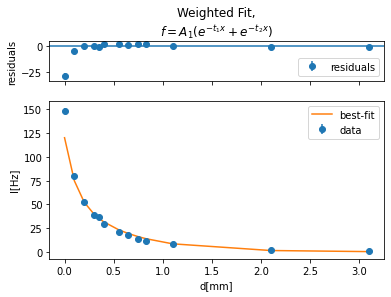

In [13]:
decay = lambda x,A,t: A*np.exp(x*t)
double_decay = lambda x,A1,t1,A2,t2: decay(x,A1,t1)+A2*decay(x,A1,t2)
ddmodel = Model(double_decay)
# for par in ddmodel.param_names:
ddmodel.set_param_hint("A1",min = 0)
ddmodel.set_param_hint("A2",min = ratiomin)
ddmodel.set_param_hint("A2",min = ratiomax)
ddmodel.set_param_hint("t1",max = 0)
ddmodel.set_param_hint("t2",max = 0)
ddresult = ddmodel.fit(nv(erange_I),x=nv(erange_d),A1=nv(erange_I).max()/2, A2=(ratiomin+ratiomax)/2,
                       t1=-1,t2=-10,weights=1/sd(erange_I))
fig = plt.figure()
fig, gridspec = ddresult.plot(fig=fig,yerr=sd(erange_I),ylabel='I[Hz]',xlabel='d[mm]')
# fig.get_axes()[1].set_yscale("log")
fig.get_axes()[0].set_title("Weighted Fit,\n$f=A_1(e^{-t_1x}+e^{-t_2x})$")
# fig.suptitle("Weighted fit")
print(str.format(ddresult.fit_report()))

In [14]:
print(-np.log(1/1000)/ddresult.params['t1'].value,ddresult.params['t1'].stderr)
print(-np.log(1/1000)/ddresult.params['t2'].value,ddresult.params['t2'].stderr)

-3.795597421948458 None
-0.7408997664745914 None
